<a href="https://colab.research.google.com/github/brockmanmatt/gdelt_news_exploration/blob/master/git_update_death_data_from_jh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


This notebook is a place to start for pulling COVID death data over time

It clones the repo of john hopkins data from https://github.com/CSSEGISandData/COVID-19

Then it graphs aggregate US deaths over time along with different doubling rates
It also graphs individual state deaths over time (only selecting states with 2 days over 30 culumulative deaths)


In [1]:
### Clone John Hopkins data

!git clone https://github.com/CSSEGISandData/COVID-19.git || (cd COVID-19 ; git pull)

Cloning into 'COVID-19'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 15476 (delta 5), reused 10 (delta 4), pack-reused 15457
Receiving objects: 100% (15476/15476), 49.64 MiB | 43.90 MiB/s, done.
Resolving deltas: 100% (7518/7518), done.


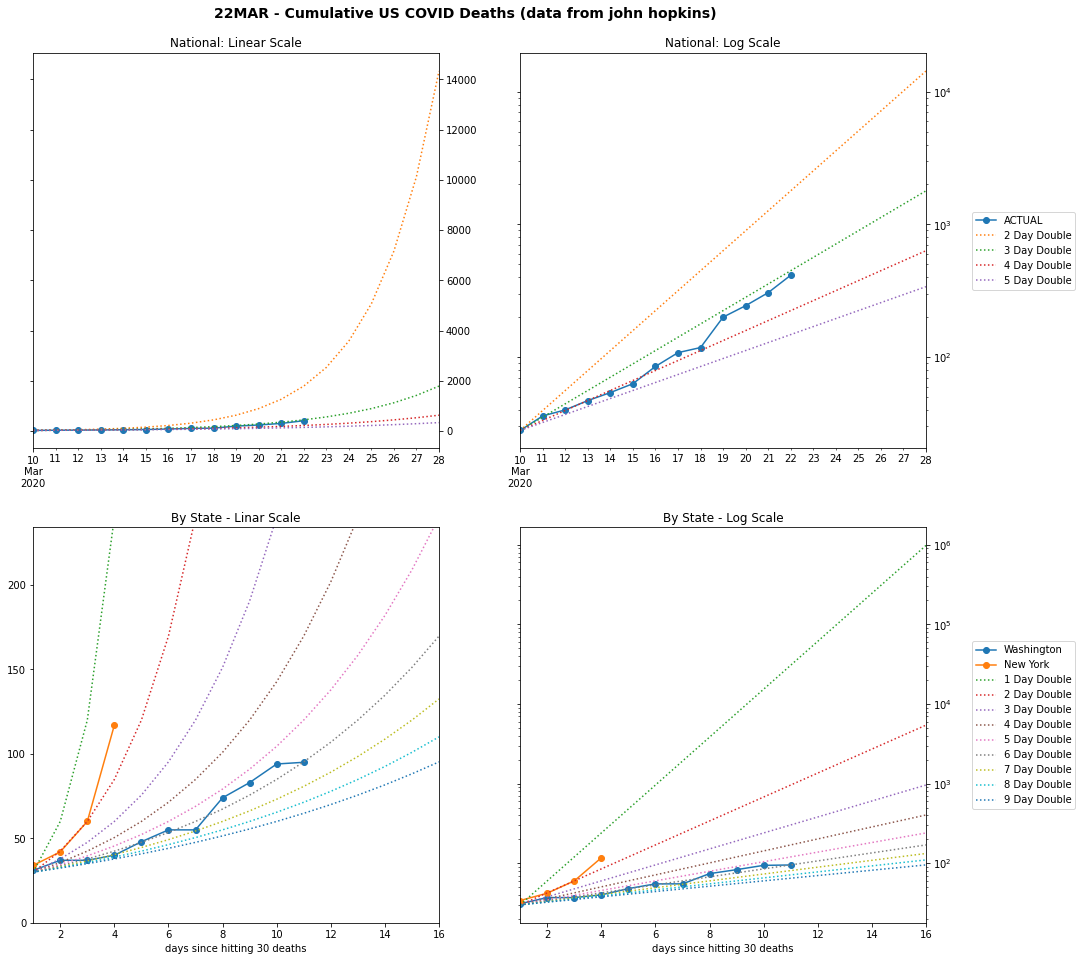

In [4]:
### Graph aggregate US deaths over time

import matplotlib.pyplot as plt
import datetime as dt, numpy as np, pandas as pd

import warnings
warnings.filterwarnings('ignore')



#This is a list of all US states; I'm lazy and just copied from somewhere so I gotta pull them out and put into states
states = '"Alabama","AL" "Alaska","AK" "Arizona","AZ" "Arkansas","AR" "California","CA" "Colorado","CO" "Connecticut","CT" "Delaware","DE" "District of Columbia","DC" "Florida","FL" "Georgia","GA" "Hawaii","HI" "Idaho","ID" "Illinois","IL" "Indiana","IN" "Iowa","IA" "Kansas","KS" "Kentucky","KY" "Louisiana","LA" "Maine","ME" "Montana","MT" "Nebraska","NE" "Nevada","NV" "New Hampshire","NH" "New Jersey","NJ" "New Mexico","NM" "New York","NY" "North Carolina","NC" "North Dakota","ND" "Ohio","OH" "Oklahoma","OK" "Oregon","OR" "Maryland","MD" "Massachusetts","MA" "Michigan","MI" "Minnesota","MN" "Mississippi","MS" "Missouri","MO" "Pennsylvania","PA" "Rhode Island","RI" "South Carolina","SC" "South Dakota","SD" "Tennessee","TN" "Texas","TX" "Utah","UT" "Vermont","VT" "Virginia","VA" "Washington","WA" "West Virginia","WV" "Wisconsin","WI" "Wyoming","WY"'
tmp = states.split('" "')
states = [x.split(",")[0].replace('"', "") for x in tmp]

#Load global death data, pull just the US ones
all = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv")
us = all[all["Country/Region"] == "US"]
us = us[us["Province/State"].isin(states)]
us_deaths = us[[x for x in us.columns if x.find("/20") > -1]].dropna(axis="columns")
#Aggregate US Deaths by Day
total_deaths = us_deaths.sum()

#Start where deaths > 0, this'll be actual
td = pd.DataFrame(total_deaths[total_deaths > 0])
td.index = pd.to_datetime(td.index)
td.columns = ["ACTUAL"]
td = td.T

#Set up to go a few days into the future
maxDate = td.columns.max()
try:
    for i in range(1,7):
        td[str(maxDate + dt.timedelta(days=i))] = np.NaN
except:
    pass
td = td.T

td.index = pd.to_datetime(td.index)

td["day"] = range(len(td))


#Figure out math for exponents for exponential growth
days = pd.DataFrame()
days["d"] = range(2,6)
#daily rate to double every x days
days["r"] = days.d.apply(lambda x: 2**(1/(x)))

#Give value of expected value along each exponential for doubling period
for i in range(len(days)):
    td["{} Day Double".format(i+2)] = td["day"].apply(lambda x:28 *(days.r[i]**x))


#set up plots
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(16,16), facecolor="w")
td[[x for x in td.columns if x != "day"]].plot(style=["o-", ":", ":", ":", ":", ":"], title="National: Linear Scale", ax = ax1)
td[[x for x in td.columns if x != "day"]].plot(style=["o-", ":", ":", ":", ":", ":"], logy=True, title="National: Log Scale", ax = ax2)


ax1.yaxis.tick_right()
ax1.yaxis.set_ticks_position('both')

ax2.yaxis.tick_right()
ax2.yaxis.set_ticks_position('both')

ax1.get_legend().remove()
ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))


#
#
#  BY STATE
#

tmp = us[["Province/State"] + [x for x in us.columns if x.find("/20") > -1]].dropna(axis="columns").set_index("Province/State", drop=True).T

#Create DF for each state, keeping only days where cumulative deaths is above 30
state_dfs = {}
for state in tmp.columns:
    state_dfs[state] = tmp[[state]]
    state_dfs[state] = state_dfs[state][state_dfs[state][state] >= 30]


max_days = 0
max_deaths = 0


#for each state, if more than 2 days above 30 deaths, plot it
for state in state_dfs:
    if len(state_dfs[state]) > 2:
        if len(state_dfs[state]) > max_days:
            max_days = len(state_dfs[state])
        
        asdf = state_dfs[state].copy()
        if asdf[state].max() > max_deaths:
            max_deaths = asdf[state].max()
        
        #resetting index to days at 30 or more
        asdf.index = range(1, len(asdf)+1)
        asdf.plot(ax=ax3, style="o-")
        asdf.plot(ax=ax4, style="o-", logy=True)


#set up my extrapolation on the exponentials figuring out the doubling rates
days = pd.DataFrame()
days["d"] = range(1,10)
#daily rate to double every x days
days["r"] = days.d.apply(lambda x: 2**(1/(x)))

td = pd.DataFrame([x for x in range(max_days + 6)])
td.columns=["day"]

for i in range(len(days)):
    td["{} Day Double".format(i+1)] = td["day"].apply(lambda x:30 *(days.r[i]**x))

td = td.shift()
td = td[1:]
#gonna plot exponentials directly so dropping the "day" column
td.drop(columns="day", inplace=True)

td.plot(style=":", ax=ax3)
td.plot(style=":", ax=ax4)

ax3.set_title("By State - Linar Scale")
ax3.set_xlabel("days since hitting 30 deaths")
ax3.get_legend().remove()

ax4.set_title("By State - Log Scale")
ax4.yaxis.tick_right()
ax4.yaxis.set_ticks_position('both')
ax4.set_xlabel("days since hitting 30 deaths")
ax4.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))


#just make the ymax a bit higher
ax3.set_ylim(0, max_deaths * 2)

fig.suptitle("22MAR - Cumulative US COVID Deaths (data from john hopkins)", y=.92, fontsize=14, weight="bold")


plt.show()